In [1]:
%matplotlib widget

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.tri import Triangulation
import pygeodesic.geodesic as geodesic

## Define the surface by a fn of x and y

In [24]:
def func(x, y):
    return np.sin(0.5*x) * np.sin(0.5*y) + 3

## Visualize the surface

matplotlib actually has a built in triangulation algorithm. It's not complicated, it just uses a square mesh that you provide,
but so long as there are no cliffs, or spikes etc on your surface, this will work. Play with the discretization to get a sense
for the resolution you need to approximate your surface.

(0.0, 5.0)

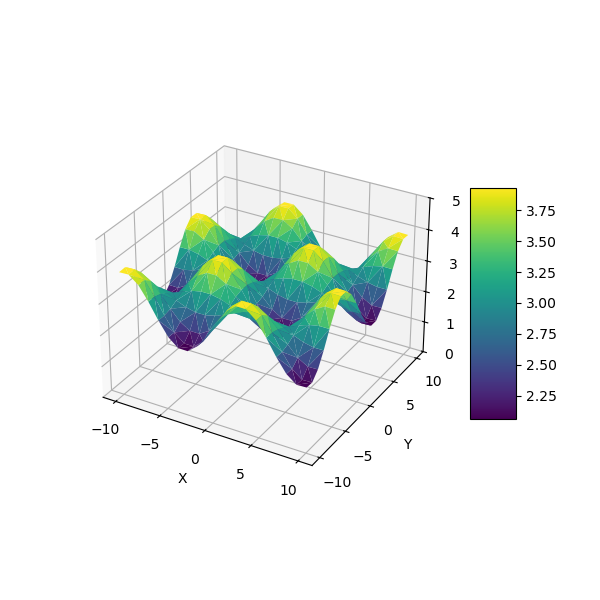

In [28]:
# Control discretization size by increasing or decreasing number of grid points
NUM_GRIDPOINTS_PER_DIMENSION = 20

x = np.linspace(-10, 10, NUM_GRIDPOINTS_PER_DIMENSION)
y = np.linspace(-10, 10, NUM_GRIDPOINTS_PER_DIMENSION)
X, Y = np.meshgrid(x, y)
Z = func(X, Y)

# Create triangulation
tri = Triangulation(X.flatten(), Y.flatten())

# Create plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

# Plot the triangular mesh
surf = ax.plot_trisurf(X.flatten(), Y.flatten(), Z.flatten(), 
                       triangles=tri.triangles, cmap='viridis')

# Add labels and colorbar
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
fig.colorbar(surf, shrink=0.5, aspect=5)

# Set z-range (optional)
ax.set_zlim(0,5)

### Serialize the triangulation to an input file for pygeodesic

The `matplotlib` `Triangulation` object actually has the vertices and triangles ready for us, so we just arrange them in the format used in the `pygeodesic` library. 

In [29]:
vertex_zs = func(tri.x, tri.y)
vertices = np.array([tri.x, tri.y, vertex_zs]).T
triangles = tri.triangles
num_vertices = len(vertices)
num_triangles = len(tri.triangles)

In [30]:
print(f"Counted {num_vertices} vertices and {num_triangles} triangles")

Counted 400 vertices and 722 triangles


In [31]:
# Construct an input file of this format: https://github.com/mhogg/pygeodesic/blob/main/pygeodesic/examples/data/flat_triangular_mesh.txt
# The format of this file is:
# 1. A header line with first the number of vertices and second the number of triangles
# 2. A list of vertices
# 3. A list of triangles defined by the indices of the three vertices of their corners

def make_line_from_nums(nums):
    return " ".join([str(round(n, 6)) for n in nums]) + "\n"

mesh_fname = "mesh.txt"
with open(mesh_fname, "w+") as f:
    # Write header line
    f.writelines([f"{num_vertices} {num_triangles}\n"])

    # Write lines for each vertex in the mesh
    vertex_lines = [make_line_from_nums(v) for v in vertices]
    f.writelines(vertex_lines)

    # Write lines for each triangle (a list of the indices of the three vertices constituting it)
    triangle_lines = [make_line_from_nums(v) for v in tri.triangles]

    # Remove trailing whitespace
    triangle_lines[-1] = triangle_lines[-1].rstrip("\n")
    f.writelines(triangle_lines)

## Define start and end points

## NOTE: The pygeodesic algorithm finds paths between _vertices_

#### But at first I thought it used _triangles_, so I have a little algo here to find which triangle a point is inside

For this, you'll need to identify which triangle your point is inside. We can do this in 2D, since the triangulation is performed on the 2D mesh.

This is actually kind of an interesting problem, but there's a fun method where we:

1. Calculate the area of the full triangle
2. Observe that there are three sub-triangles defined by the point in question and the three pairs of the triangle corners.
3. Calculate the area of each of these subtriangles.
4. Check if the sum of the areas of the sub-triangles is equal to the area of the full triangle.
    - If it is, then the point is inside the triangle
    - If it is not, then the point is outside the triangle



### You can ignore this, but it's kinda cool

In [110]:
def is_point_in_triangle(pt, v1, v2, v3):
    """
    Check if a point is inside a triangle defined by three vertices.

    Parameters:
    pt : tuple
        A tuple representing the point (x, y).
    v1, v2, v3 : tuple
        Tuples representing the triangle vertices (x, y).

    Returns:
    bool
        True if the point is inside the triangle, False otherwise.
    """
    # Unpack the points
    x, y = pt
    x1, y1 = v1
    x2, y2 = v2
    x3, y3 = v3

    # Calculate area of the triangle
    area_ABC = abs((x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2)) / 2.0)
    
    # Calculate area of sub-triangles
    area_PAB = abs((x*(y1 - y2) + x1*(y2 - y) + x2*(y - y1)) / 2.0)
    area_PBC = abs((x*(y2 - y3) + x2*(y3 - y) + x3*(y - y2)) / 2.0)
    area_PCA = abs((x*(y3 - y1) + x3*(y1 - y) + x1*(y - y3)) / 2.0)

    # Check if the sum of the areas of the sub-triangles is equal to the area of the triangle
    return np.isclose(area_ABC, area_PAB + area_PBC + area_PCA)

def get_containing_triangle_index(point, triangulation):
    triangle_idx = None
    for idx, triangle in enumerate(triangulation.triangles):
        vertices = [(tri.x[idx], tri.y[idx]) for idx in triangle]

        point_contained = is_point_in_triangle(point, *vertices)
        if point_contained:
            # Uncomment for debugging
            # print(vertices)            
            if triangle_idx is not None:
                print("BUG: Multiple triangles identified containing this point :(")
                print("If this message appears only once, your point may be exactly on the edge between two triangles")
                print("If it appears multiple times, this algorithm is wrong :grimacing:")
            triangle_idx = idx

    if triangle_idx is None:
        raise ValueError("No triangle containing this point was located")
    return triangle_idx

In [111]:
test_tri_1 = [(0,0), (1,0), (0,1)]
test_tri_2 = [(-1.5,-2), (-0.5, -2), (-0.5, -1)]

pt1 = (0.25, 0.25)
assert is_point_in_triangle(pt1, *test_tri_1)
assert not is_point_in_triangle(pt1, *test_tri_2)

pt2 = (0.75, 0.35)
assert not is_point_in_triangle(pt2, *test_tri_1)
assert not is_point_in_triangle(pt2, *test_tri_2)

pt3 = (-1, -1.9)
assert not is_point_in_triangle(pt3, *test_tri_1)
assert is_point_in_triangle(pt3, *test_tri_2)

### Stop ignoring here

## Use this to get the idx of your the vertices closest to your starting and ending pts

In [112]:
def get_closest_vertex(pt, triangulation):
    np_pt = np.array(pt)
    vertices = np.array([triangulation.x, triangulation.y]).T
    dists = [np.linalg.norm(np_pt - v) for v in vertices] 
    closest_idx = np.argmin(dists)
    return closest_idx

In [116]:
starting_point = (-9.1, 2)
ending_point = (8, 8)

starting_triangle = get_containing_triangle_index(starting_point, tri)
starting_vertex = get_closest_vertex(starting_point, tri)

ending_triangle =  get_containing_triangle_index(ending_point, tri)
ending_vertex = get_closest_vertex(ending_point, tri)
print(f"Identified triangle {starting_triangle} as the start point and triangle {ending_triangle} as the end point")
print(f"Identified vertex {starting_vertex} as the start point and vertex {ending_vertex} as the end point")

Identified triangle 161 as the start point and triangle 333 as the end point
Identified vertex 221 as the start point and vertex 357 as the end point


## Do some path finding

Literally just use the code from the example in pygeodesic to find the path. The path is returned as well as the distance.

I _think_ the path is a list of triangle centers, so we can visualize it by plotting those points as a line plot.

In [117]:
# From: https://github.com/mhogg/pygeodesic/blob/main/pygeodesic/examples/pygeodesic_intro.ipynb
# Read our input file

result = geodesic.read_mesh_from_file(mesh_fname)
if result:
    points, faces = result

# From: https://github.com/mhogg/pygeodesic/blob/main/pygeodesic/examples/pygeodesic_intro.ipynb
# Instantiate our algorithm object
geoalg = geodesic.PyGeodesicAlgorithmExact(points,faces)

# https://github.com/mhogg/pygeodesic/blob/main/pygeodesic/examples/pygeodesic_intro.ipynb
# Find the path between triangles, specify them by their indices

distance, path = geoalg.geodesicDistance(starting_vertex, ending_vertex)

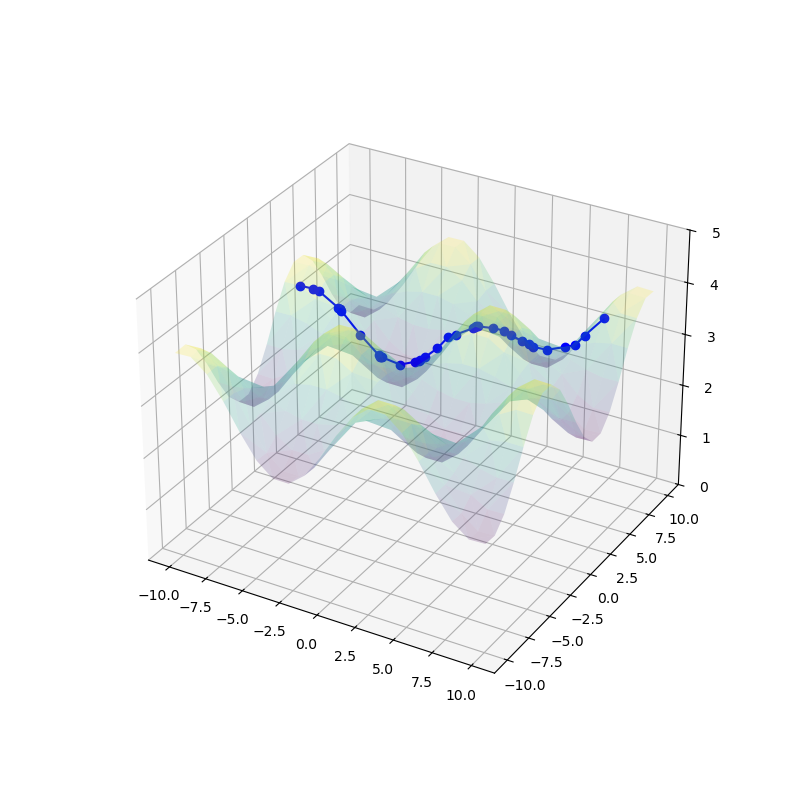

In [120]:

# Create plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

# Plot the triangular mesh
surf = ax.plot_trisurf(X.flatten(), Y.flatten(), Z.flatten(), 
                       triangles=tri.triangles, cmap='viridis', alpha=0.2)

# Set z-range (optional)
ax.set_zlim(0,5)


# Step 2: Extract x, y, and z coordinates
x, y, z = zip(*path)

ax.plot(x, y, z, marker='o', linestyle='-', color='b')  # Line with markers

# Show the plot
plt.show()